#### This code runs Random Forest Algorithm to estimate CRE EL intensity from prepared data created using CRE Data Preparation.ipynb

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
data_cbecs_final = pd.read_excel('data_cbecs_final.xlsx')

In [3]:
data_cbecs_final.head()

,SQFT,RFCOOL,GLSSPC,NFLOOR,FLCEILHT,ATTIC,YRCONC,RENOV,FACIL,GOVOWN,...,LNHRPC_4.0,LNHRPC_5.0,LTEXPC_1.0,LTEXPC_2.0,LTEXPC_3.0,LTEXPC_4.0,WINTYP_1,WINTYP_2,WINTYP_3,WINTYP_4
0,210000,0,3,994,12,0,2,1.0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,28000,1,3,5,8,0,6,1.0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,2100,0,3,1,9,1,6,1.0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,240000,1,2,1,25,0,9,NaN,0,0,...,0,0,0,1,0,0,0,1,0,0
4,295000,0,1,1,30,0,4,0.0,0,0,...,0,0,0,0,0,1,0,1,0,0


#### Using Cross Validation to find the optimal random forest

In [4]:
SEED = 75

train_data, test_data = train_test_split(data_cbecs_final, test_size=0.25, random_state=SEED)
y_train = train_data['EL Intensity']
x_train = train_data.drop(columns=['EL Intensity','FINALWT'])
weight_train = train_data['FINALWT']
weight_train.fillna(0,inplace=True) #assign 0 weights to null for weights
x_train.fillna(-100,inplace=True) # assing negative values to null in train data for easy identification

In [5]:
# the following code finds the optimal depth as the hyperparameter for optimal random forest construction
i=1
score = 0
while True:
    model = RandomForestRegressor(n_estimators=100,max_depth=i, min_samples_split=30, min_samples_leaf = 30)
    scores = cross_val_score(model,x_train,y_train,cv=5,fit_params={'sample_weight':weight_train})
    score_new = scores.mean()
    print(f"depth {i}")
    print(f"score {score_new}")
    if score < score_new:
        score = score_new
        i=i+1
    else:
        break
        
optimal_depth = i-1
print(f"optimal depth {optimal_depth}")
print (f"optimal score {score}")

depth 1
score 0.1638306525853899
depth 2
score 0.23250407417639618
depth 3
score 0.330820828759418
depth 4
score 0.38395764436990404
depth 5
score 0.39569845661955105
depth 6
score 0.4082475656076242
depth 7
score 0.4209038510345568
depth 8
score 0.42680207453103575
depth 9
score 0.43688747706058634
depth 10
score 0.4367656715800946
optimal depth 9
optimal score 0.43688747706058634


In [7]:
#prepare test data
y_test = test_data['EL Intensity']
x_test = test_data.drop(columns = ['EL Intensity', 'FINALWT'])

x_test.fillna(-100,inplace=True)

weight_test = test_data['FINALWT']
weight_test.fillna(0,inplace=True)


In [8]:
#create the optimal random forest
optimal_model = RandomForestRegressor(n_estimators=100,min_samples_split=30,min_samples_leaf=30)
optimal_model.fit(x_train,y_train,sample_weight=weight_train)
y_test_pred = optimal_model.predict(x_test)
score_test = r2_score(y_test,y_test_pred,sample_weight=weight_test)

print(f"score on test data {score_test}")

score on test data 0.4836954013915151


In [13]:
# calculate the relative importance of features
feature_importance = len(list(optimal_model.feature_importances_))
feature_importance_dict = dict(zip(list(x_train.columns),list(optimal_model.feature_importances_)))
material_features = {k:v for k,v in feature_importance_dict.items() if v > 0.005 }
sorted_dict = dict(sorted(material_features.items(),key=lambda x: x[1]))

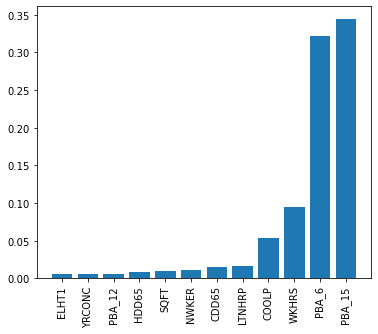

In [14]:
#plot feature importance 
w = 6
h = 6
fig = plt.figure(figsize=(w,h))
ax= fig.add_subplot(111)
plt.subplots_adjust(bottom=0.25)
x=sorted_dict.keys()
y=sorted_dict.values()
ax.bar(x,y)
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x,rotation=90)
plt.show()